# Testing the Implementation on Various Pre-Trained Models

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from helper import W8A16LinearLayer, replace_linear_with_target_and_quantize

### Test Model 1 : [Salesforce/codegen-350M-mono](https://huggingface.co/Salesforce/codegen-350M-mono)

In [126]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "Salesforce/codegen-350M-mono"

model = AutoModelForCausalLM.from_pretrained(model_id,
                                    torch_dtype=torch.bfloat16,
                                             low_cpu_mem_usage=False)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [127]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

In [128]:
print(pipe("def Hello_World():", max_new_tokens=20, do_sample=False)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def Hello_World():
    print("Hello World")

Hello_World()

# 파


In [129]:
print ("Initial Model: ")
print (model)

Initial Model: 
CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bi

In [130]:
prev_memory_footprint = model.get_memory_footprint()
print("Footprint of the model in MBs: ", prev_memory_footprint/1e+6)

Footprint of the model in MBs:  797.310976


In [131]:
replace_linear_with_target_and_quantize(model,W8A16LinearLayer,['lm_head'])

We can observe that our custom quantizer replaced all the nn.Linear layers except for "lm_head"

In [132]:
print ("Model after Quantization: ")
print (model)

Model after Quantization: 
CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)


In [133]:
print(pipe("def Hello_World():", max_new_tokens=20, do_sample=False)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def Hello_World():
    print("Hello World")

def Hello_World_2():
    print("


In [134]:
new_memory_footprint = model.get_memory_footprint()
print("Footprint of the model in MBs: ", new_memory_footprint/1e+6)

print ("\n Size Reduced By", (prev_memory_footprint - new_memory_footprint)/prev_memory_footprint*100, "%")

Footprint of the model in MBs:  546.021376

 Size Reduced By 31.517137925365773 %


### Test Model 2 : [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50)

In [135]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")

In [136]:
previous_memory_footprint = model.get_memory_footprint()

In [137]:
prev_memory_footprint = model.get_memory_footprint()
print("Footprint of the model in MBs: ",prev_memory_footprint/1e+6)

Footprint of the model in MBs:  166.524032


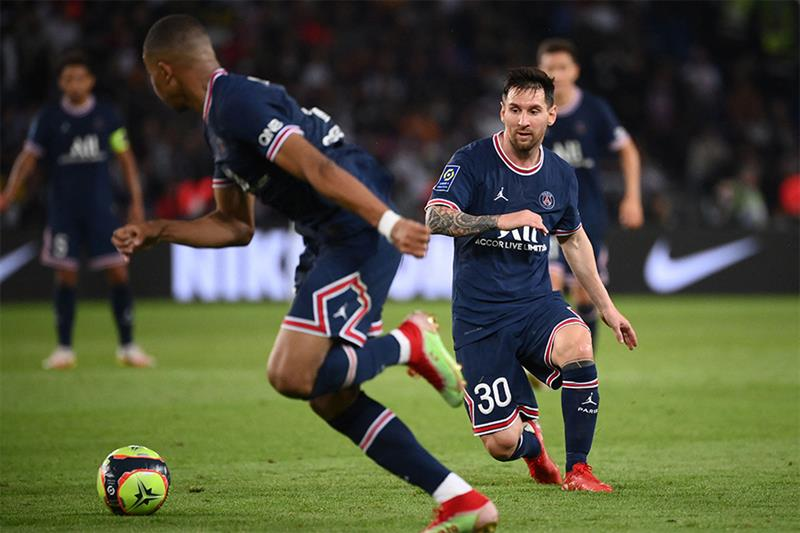

In [138]:
img_path = "/content/football.jpg"
image = Image.open(img_path).convert("RGB")
image

In [139]:
from helper import plot_results

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

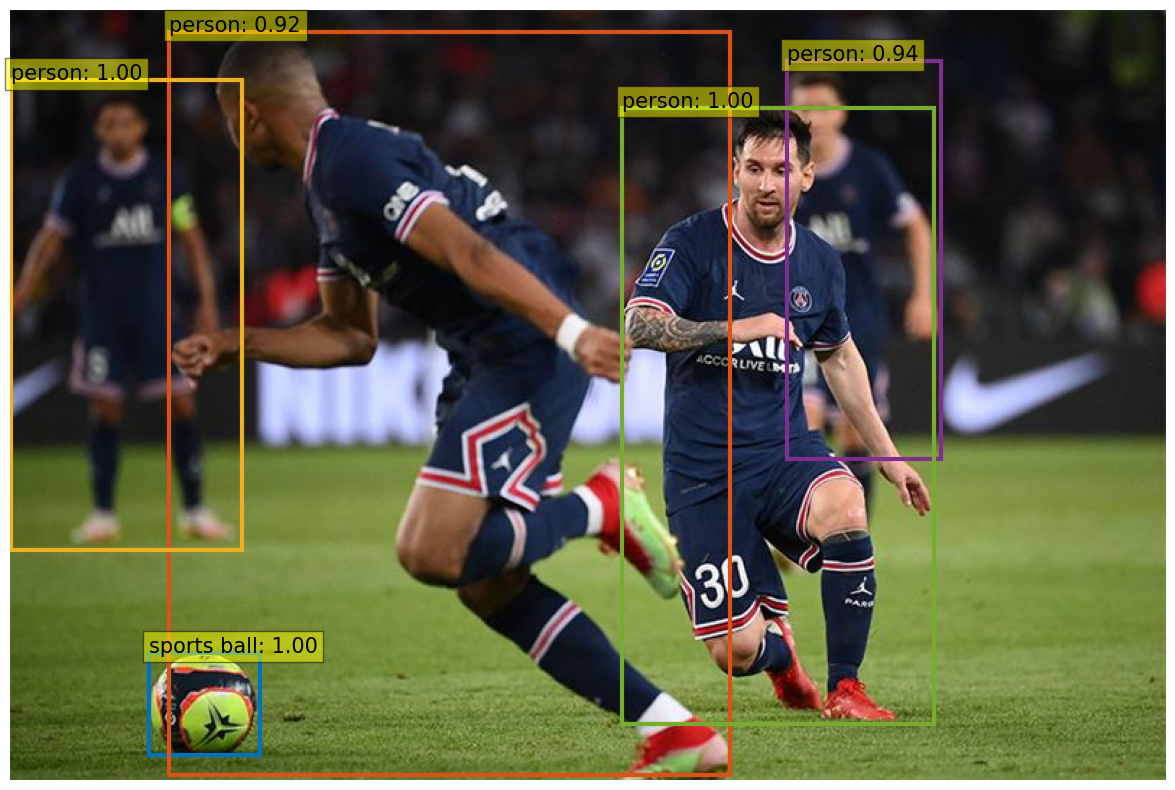

In [140]:
plot_results(model, image, results)

In [141]:
print ("Initial Model: ")
print (model)

Initial Model: 
DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                

In [142]:
replace_linear_with_target_and_quantize(model, W8A16LinearLayer, ["0", "1", "2", "class_labels_classifier"])

We can observe that our custom quantizer replaced all the nn.Linear layers except for "0", "1", "2", "class_labels_classifier"

In [143]:
print ("Model after Quantization: ")
print (model)

Model after Quantization: 
DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
     

In [144]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

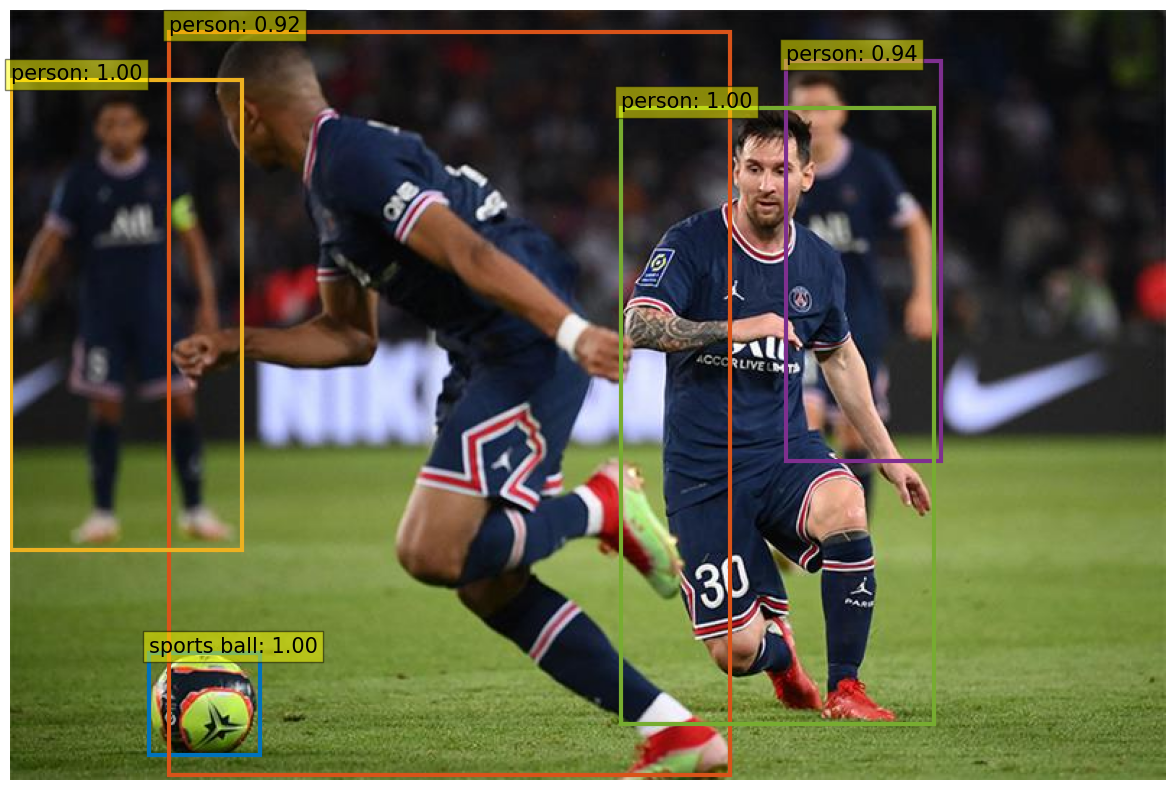

In [145]:
plot_results(model, image, results)

In [146]:
new_memory_footprint = model.get_memory_footprint()
print("Footprint of the model in MBs: ", new_memory_footprint/1e+6)

print ("\n Size Reduced By", (prev_memory_footprint - new_memory_footprint)/prev_memory_footprint*100, "%")

Footprint of the model in MBs:  114.80384

 Size Reduced By 31.0586954800614 %
